# Housing sale price prediction (Kaggle)
https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import pickle as pk
from time import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [2]:
data = pd.read_csv('train.csv')
practice = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [3]:
label = data.pop('SalePrice')

In [4]:
def pre_process(df_train, df_test):
    # Convert all df to str
    df_train = df_train.applymap(lambda x: str(x))
    df_test = df_test.applymap(lambda x: str(x))
    # replace NaN by 0
    df_train.fillna('0', inplace=True) # if fill with int(0), label encoder fails
    df_test.fillna('0', inplace=True)
    # Drop Id
    df_train.drop('Id', axis=1, inplace=True)
    df_test.drop('Id', axis=1, inplace=True)
    # Label encode each non numerical features
    dict_encoder = {}
    for col in list(df_train.select_dtypes(include='object')):
        le = LabelEncoder()
        le.fit(list(df_train[col])+list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        dict_encoder[col] = le
    # Re-convert all df to float
    df_train = df_train.applymap(lambda x: float(x))
    df_test = df_test.applymap(lambda x: float(x))
    return df_train, df_test, dict_encoder

In [5]:
data, practice, dict_encoder = pre_process(data, practice)

In [6]:
enc = dict_encoder['MSZoning']
print('MSZoning'+' classes:',list(enc.classes_))

enc = dict_encoder['Fence']
print('Fence'+' classes:',list(enc.classes_))

MSZoning classes: ['C (all)', 'FV', 'RH', 'RL', 'RM', 'nan']
Fence classes: ['GdPrv', 'GdWo', 'MnPrv', 'MnWw', 'nan']


In [7]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,10.0,3.0,93.0,1586.0,1.0,2.0,3.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7.0,4.0,110.0,53.0,1.0,1.0,12.0,13.0,1.0,99.0,2.0,4.0,2.0,2.0,3.0,3.0,2.0,1016.0,5.0,0.0,341.0,1270.0,1.0,0.0,1.0,4.0,951.0,536.0,0.0,599.0,2.0,0.0,2.0,1.0,3.0,1.0,2.0,12.0,6.0,0.0,5.0,1.0,94.0,1.0,4.0,483.0,4.0,4.0,2.0,0.0,213.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,4.0,2.0,8.0,4.0
1,5.0,3.0,108.0,1862.0,1.0,2.0,3.0,3.0,0.0,2.0,0.0,24.0,1.0,2.0,0.0,2.0,6.0,7.0,83.0,26.0,1.0,1.0,8.0,8.0,2.0,0.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1288.0,5.0,0.0,662.0,337.0,1.0,0.0,1.0,4.0,234.0,0.0,0.0,217.0,0.0,2.0,2.0,0.0,3.0,1.0,3.0,10.0,6.0,1.0,4.0,1.0,67.0,1.0,4.0,340.0,4.0,4.0,2.0,193.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,7.0,1.0,8.0,4.0
2,10.0,3.0,96.0,282.0,1.0,2.0,0.0,3.0,0.0,4.0,0.0,5.0,2.0,2.0,0.0,5.0,7.0,4.0,108.0,52.0,1.0,1.0,12.0,13.0,1.0,70.0,2.0,4.0,2.0,2.0,3.0,2.0,2.0,730.0,5.0,0.0,898.0,1345.0,1.0,0.0,1.0,4.0,1008.0,545.0,0.0,654.0,2.0,0.0,2.0,1.0,3.0,1.0,2.0,10.0,6.0,1.0,4.0,1.0,92.0,1.0,4.0,568.0,4.0,4.0,2.0,0.0,187.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,11.0,2.0,8.0,4.0
3,11.0,3.0,88.0,1850.0,1.0,2.0,0.0,3.0,0.0,0.0,0.0,6.0,2.0,2.0,0.0,5.0,7.0,4.0,25.0,20.0,1.0,1.0,13.0,15.0,2.0,0.0,3.0,4.0,0.0,3.0,1.0,3.0,0.0,392.0,5.0,0.0,1046.0,1148.0,1.0,2.0,1.0,4.0,1046.0,463.0,0.0,604.0,2.0,0.0,1.0,0.0,3.0,1.0,2.0,11.0,6.0,1.0,2.0,5.0,89.0,2.0,6.0,618.0,4.0,4.0,2.0,0.0,172.0,116.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,4.0,0.0,8.0,0.0
4,10.0,3.0,112.0,688.0,1.0,2.0,0.0,3.0,0.0,2.0,0.0,15.0,2.0,2.0,0.0,5.0,8.0,4.0,107.0,50.0,1.0,1.0,12.0,13.0,1.0,228.0,2.0,4.0,2.0,2.0,3.0,0.0,2.0,952.0,5.0,0.0,981.0,195.0,1.0,0.0,1.0,4.0,133.0,25.0,0.0,896.0,2.0,0.0,2.0,1.0,4.0,1.0,2.0,13.0,6.0,1.0,4.0,1.0,91.0,1.0,6.0,804.0,4.0,4.0,2.0,90.0,236.0,0.0,0.0,0.0,0.0,3.0,4.0,4.0,0.0,3.0,2.0,8.0,4.0


In [8]:
X = np.array(data)
y = np.array(label)
print('X shape:',X.shape)
print('y shape:',y.shape)

X shape: (1460, 79)
y shape: (1460,)


## Machine learning

In [9]:
# Generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Size of sets
print("Train set:",X_train.shape)
print("Train set:",y_train.shape)
print("Test set:",X_test.shape)
print("Test set:",y_test.shape)

Train set: (1168, 79)
Train set: (1168,)
Test set: (292, 79)
Test set: (292,)


In [10]:
# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [11]:
# cross-validator : ShuffleSplit 
ss = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 42) # To avoid over-fitting

# Functions to be used in the pipeline
skb = SelectKBest(f_regression)

### Import regressor ###
reg = RandomForestRegressor()

# definition of the pipeline
pipeline = Pipeline(steps = [
    ("SKB",skb),
    ("RDFR",reg)
])   

# parameters to tune 
param_grid = {
    "SKB__k":[5,"all"],
    "RDFR__n_estimators":[100,200],
    "RDFR__max_depth":[None],
    "RDFR__min_samples_split":[2],
    "RDFR__min_samples_leaf":[2]
} 

# exhaustive search over specified parameter
grid = GridSearchCV(pipeline, param_grid, verbose = 1, cv = ss)

In [12]:
# training classifier
print (" > training classifier:")
t0 = time()
grid.fit(X_train, y_train.ravel())
print ("training time: ", round(time()-t0, 3), "s")

# best classifier using the cross-validator and the Stratified Shuffle Split 
reg = grid.best_estimator_

# predicition with the classifier
t0 = time()
pred = reg.predict(X_test)
print ("testing time: ", round(time()-t0, 3), "s")

# print grid parameters
print ("\n > Best grid search:")
print (grid.best_params_)

# dump classifier in a pickle file
print ("\n > Regressor dumped")
with open("housing_RFR_best_reg.pkl", 'wb') as file:
    pk.dump(reg, file)

 > training classifier:
Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   43.3s finished


training time:  46.313 s
testing time:  0.027 s

 > Best grid search:
{'RDFR__max_depth': None, 'RDFR__min_samples_leaf': 2, 'RDFR__min_samples_split': 2, 'RDFR__n_estimators': 200, 'SKB__k': 'all'}

 > Regressor dumped


In [13]:
RMSE = np.sqrt(mean_squared_error(y_test, pred))
R2 = r2_score(y_test, pred)
print('RMSE:',RMSE,'\nr2:',R2)

RMSE: 33223.85975719393 
r2: 0.8560915367417617


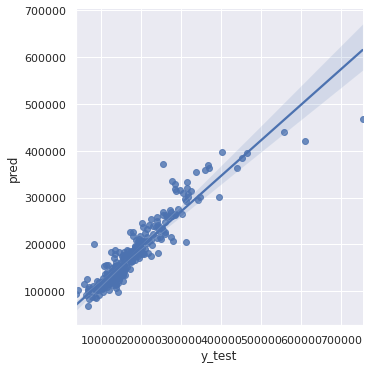

In [14]:
RFR_results = pd.DataFrame({
    'y_test':y_test,
    'pred':pred
})
sns.lmplot(data=RFR_results, x="y_test", y="pred")

In [15]:
# Submit predictions
submission = pd.DataFrame({
    'Id': pd.read_csv('test.csv')['Id'],
    'SalePrice': reg.predict(practice)
})
submission.to_csv('RFR_submission.csv', index=False)

## Deep learning

In [16]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint 
from tensorflow.keras.models import load_model

In [17]:
# l2 normalization and undoing l2 normalization (no built-in function to retrieve initial data...)
w = np.sqrt(sum(y**2)) # store sqrt of the sum

y_norm = y/w
y_norm

array([0.02761715, 0.02404083, 0.02960399, ..., 0.03529961, 0.01882536,
       0.01953731])

In [18]:
# Check good functionning
print(y_norm*w)
print(y)

[208500. 181500. 223500. ... 266500. 142125. 147500.]
[208500 181500 223500 ... 266500 142125 147500]


In [19]:
# Generate train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_norm, test_size=0.2, random_state=42)

# Size of sets
print("Train set:",X_train.shape)
print("Train set:",y_train.shape)
print("Test set:",X_test.shape)
print("Test set:",y_test.shape)

Train set: (1168, 79)
Train set: (1168,)
Test set: (292, 79)
Test set: (292,)


In [115]:
# Neural Net
model = Sequential()
model.add(Dense(units = 16, kernel_initializer = 'normal', activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(units = 16, kernel_initializer = 'normal', activation = 'relu'))
model.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 16)                1280      
_________________________________________________________________
dense_14 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 17        
Total params: 1,569
Trainable params: 1,569
Non-trainable params: 0
_________________________________________________________________


In [125]:
from keras.metrics import MeanSquaredError

# Compiling
model.compile(optimizer = 'adam', loss = 'mean_squared_logarithmic_error', metrics = ['mean_squared_logarithmic_error'])

In [126]:
# train the model
checkpointer = ModelCheckpoint(filepath='housing.nn.best.hdf5', verbose=0, save_best_only=True)

history = model.fit(
    X_train, 
    y_train, 
    validation_split=0.33, 
    epochs=100, 
    callbacks=[checkpointer],
    batch_size=32, 
    verbose=1
)

Epoch 1/100
25/25 [==============================] - 0s 12ms/step - loss: 7.8719e-05 - mean_squared_logarithmic_error: 7.8719e-05 - val_loss: 6.1603e-05 - val_mean_squared_logarithmic_error: 6.1603e-05
Epoch 2/100
25/25 [==============================] - 0s 6ms/step - loss: 4.7159e-05 - mean_squared_logarithmic_error: 4.7159e-05 - val_loss: 4.9095e-05 - val_mean_squared_logarithmic_error: 4.9095e-05
Epoch 3/100
25/25 [==============================] - 0s 6ms/step - loss: 4.0668e-05 - mean_squared_logarithmic_error: 4.0668e-05 - val_loss: 4.6871e-05 - val_mean_squared_logarithmic_error: 4.6871e-05
Epoch 4/100
25/25 [==============================] - 0s 6ms/step - loss: 4.1507e-05 - mean_squared_logarithmic_error: 4.1507e-05 - val_loss: 4.7322e-05 - val_mean_squared_logarithmic_error: 4.7322e-05
Epoch 5/100
25/25 [==============================] - 0s 5ms/step - loss: 3.8198e-05 - mean_squared_logarithmic_error: 3.8198e-05 - val_loss: 4.4757e-05 - val_mean_squared_logarithmic_error: 4.475

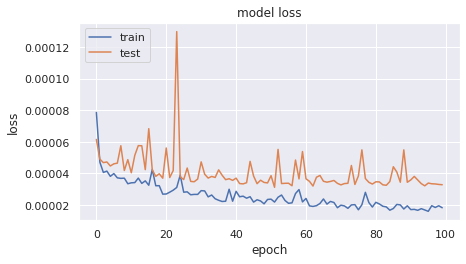

In [127]:
plt.figure(1, figsize = (15,8)) 

# summarize history for loss
plt.subplot(222) 
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [128]:
model.evaluate(X_test, y_test, verbose=0)

[3.423444286454469e-05, 3.423444286454469e-05]

In [129]:
pred = model.predict(X_test).reshape(X_test.shape[0],)

RMSE = np.sqrt(mean_squared_error(y_test, pred))
R2 = r2_score(y_test, pred)
print('RMSE:',RMSE,'\nr2:',R2)

RMSE: 0.006060949736476166 
r2: 0.7270255189409724


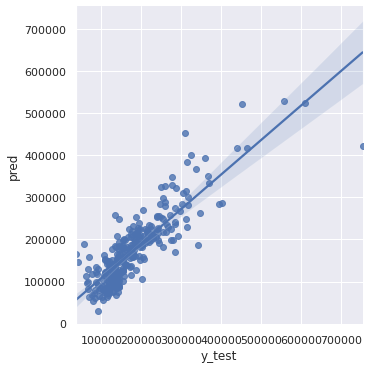

In [130]:
DL_results = pd.DataFrame({
    'y_test':y_test*w,
    'pred':model.predict(X_test).reshape(X_test.shape[0],)*w
})
sns.lmplot(data=DL_results, x="y_test", y="pred")

In [131]:
pred_norm = model.predict(practice)
pred = pred_norm.reshape(pred_norm.shape[0],)*w
pred

array([122100.016, 134130.66 , 184960.69 , ..., 135102.42 ,  58053.473,
       217306.83 ], dtype=float32)

In [132]:
# Submit predictions
submission = pd.DataFrame({
    'Id': pd.read_csv('test.csv')['Id'],
    'SalePrice': pred
})
submission.to_csv('DL_submission.csv', index=False)